In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Selected vacation dates:  4/1/17 - 4/13/17
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,4,1) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 4, 1)

In [11]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).\
        filter(Measurement.date >= year_ago).filter(Measurement.date < '2017-03-31').\
        order_by(Measurement.date).all()
# precipitation

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation, columns = ['Date','Precipitation']).sort_values('Date')
precipitation_df.head(10)

,Date,Precipitation
0,2016-04-01,0.00
1,2016-04-01,0.00
2,2016-04-01,0.00
3,2016-04-01,0.00
4,2016-04-01,0.00
5,2016-04-01,0.00
6,2016-04-01,0.02
7,2016-04-02,0.00
8,2016-04-02,0.02
9,2016-04-02,0.00


In [13]:
precip_df = precipitation_df.set_index('Date')
# precip_df['Date'] = pd.to_datetime(precip_df['Date'], format='%m/%d/%Y')
precip_df.head(10)

,Precipitation
Date,
2016-04-01,0.00
2016-04-01,0.00
2016-04-01,0.00
2016-04-01,0.00
2016-04-01,0.00
2016-04-01,0.00
2016-04-01,0.02
2016-04-02,0.00
2016-04-02,0.02


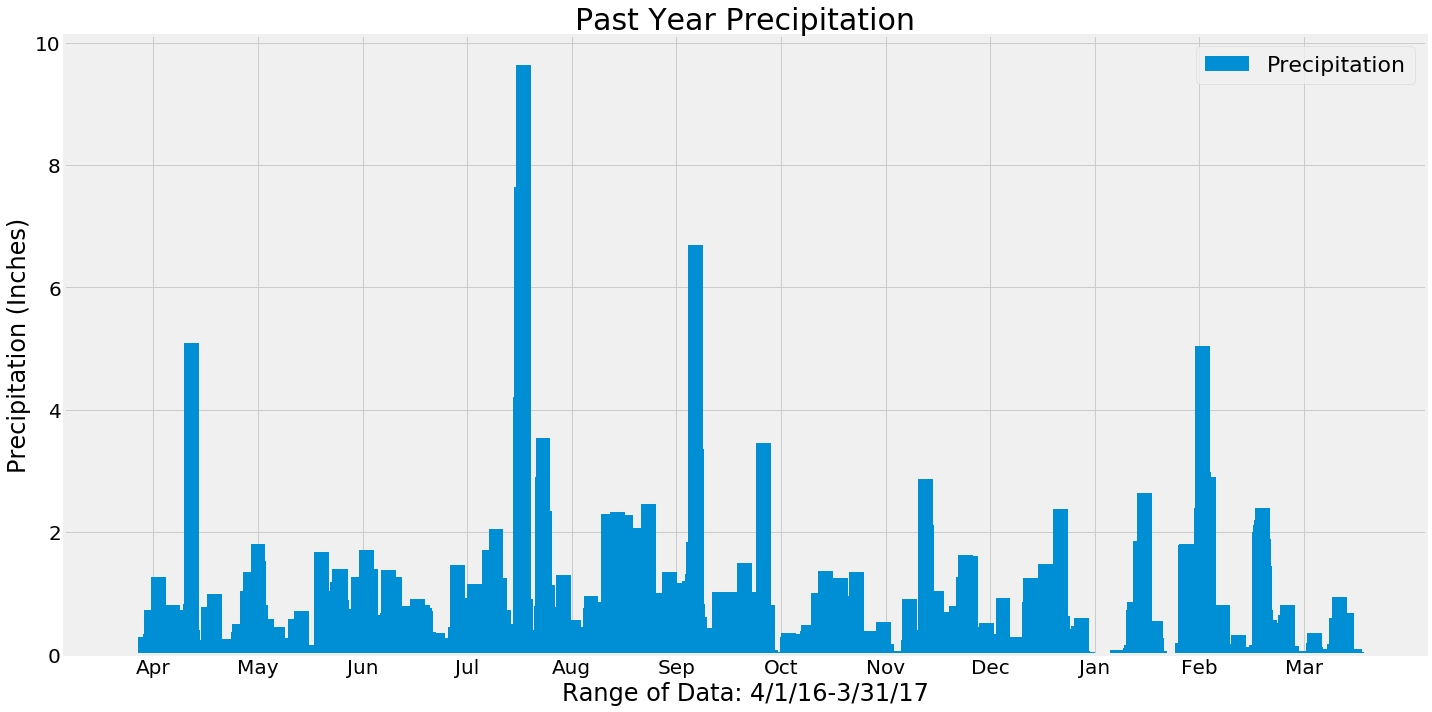

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

# Cleaned up x-tick labels and locations
# ~~~~~~~~~~~~
month = ["Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Jan","Feb","Mar"]
x = np.arange(0, len(precip_df.index.tolist()),1)
y = precip_df["Precipitation"].tolist()
months = len(y)
x_ticks = int((months / 12)*1.03)
tick_locs = [x+50 for x in range(1, months, x_ticks)]
# ~~~~~~~~~~~~

plt.figure(figsize=(20,10)) 
plt.bar(x, y, width=28, align="edge")
plt.xticks(tick_locs, month, size=20)
plt.yticks(size=20)

plt.title("Past Year Precipitation", size=30)
plt.xlabel("Range of Data: 4/1/16-3/31/17", size=24)
plt.ylabel("Precipitation (Inches)", size=24)
plt.legend(["Precipitation"], loc='best', prop={'size':22})
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2059.000000
mean,0.203536
std,0.550343
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).\
            filter(Measurement.date >= year_ago).filter(Measurement.date <= '2017-03-31').\
            group_by(Measurement.station).count()
# station_count
print(f'Number of unique stations in range of data: {station_count}')

Number of unique stations in range of data: 7


In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).\
            filter(Measurement.date >= year_ago).filter(Measurement.date <= '2017-03-31').\
            group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# most_active
most_active_df = pd.DataFrame(most_active, columns = ['Station','Count']).sort_values('Count', ascending=False)
most_active_df

,Station,Count
0,USC00513117,365
1,USC00519281,365
2,USC00519397,365
3,USC00519523,342
4,USC00516128,341
5,USC00514830,306
6,USC00517948,215


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# Since 3 stations show the same results, will use first one listed: USC00513117
temps = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.date >= year_ago).\
            filter(Measurement.date <= '2017-03-31').\
            filter(Measurement.station == 'USC00513117').\
            group_by(Measurement.station).all()
# temps
temps_df = pd.DataFrame(temps, columns = ['Station','Min Temp','Max Temp','Avg Temp'])
temps_df

,Station,Min Temp,Max Temp,Avg Temp
0,USC00513117,62.0,79.0,73.241096


In [35]:
# Choose the station with the highest number of temperature observations.
highest_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).\
            filter(Measurement.date >= year_ago).filter(Measurement.date <= '2017-03-31').\
            group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
# highest_tobs
highest_tobs_df = pd.DataFrame(highest_tobs, columns = ['Station','Temp Count'])
highest_tobs_df

,Station,Temp Count
0,USC00513117,365
1,USC00519281,365
2,USC00519397,365
3,USC00519523,342
4,USC00516128,341
5,USC00514830,306
6,USC00517948,215


In [43]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Using station USC00519281 since USC00513117 was used in previous query
station_usc00519281 = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date >= year_ago).filter(Measurement.date <= '2017-03-31').\
            order_by(Measurement.tobs).all()
# station_usc00519281
usc00519281_df = pd.DataFrame(station_usc00519281, columns = ['Station','Tobs'])
usc00519281_df.head(10)

,Station,Tobs
0,USC00519281,59.0
1,USC00519281,59.0
2,USC00519281,59.0
3,USC00519281,60.0
4,USC00519281,61.0
5,USC00519281,62.0
6,USC00519281,62.0
7,USC00519281,62.0
8,USC00519281,62.0
9,USC00519281,62.0


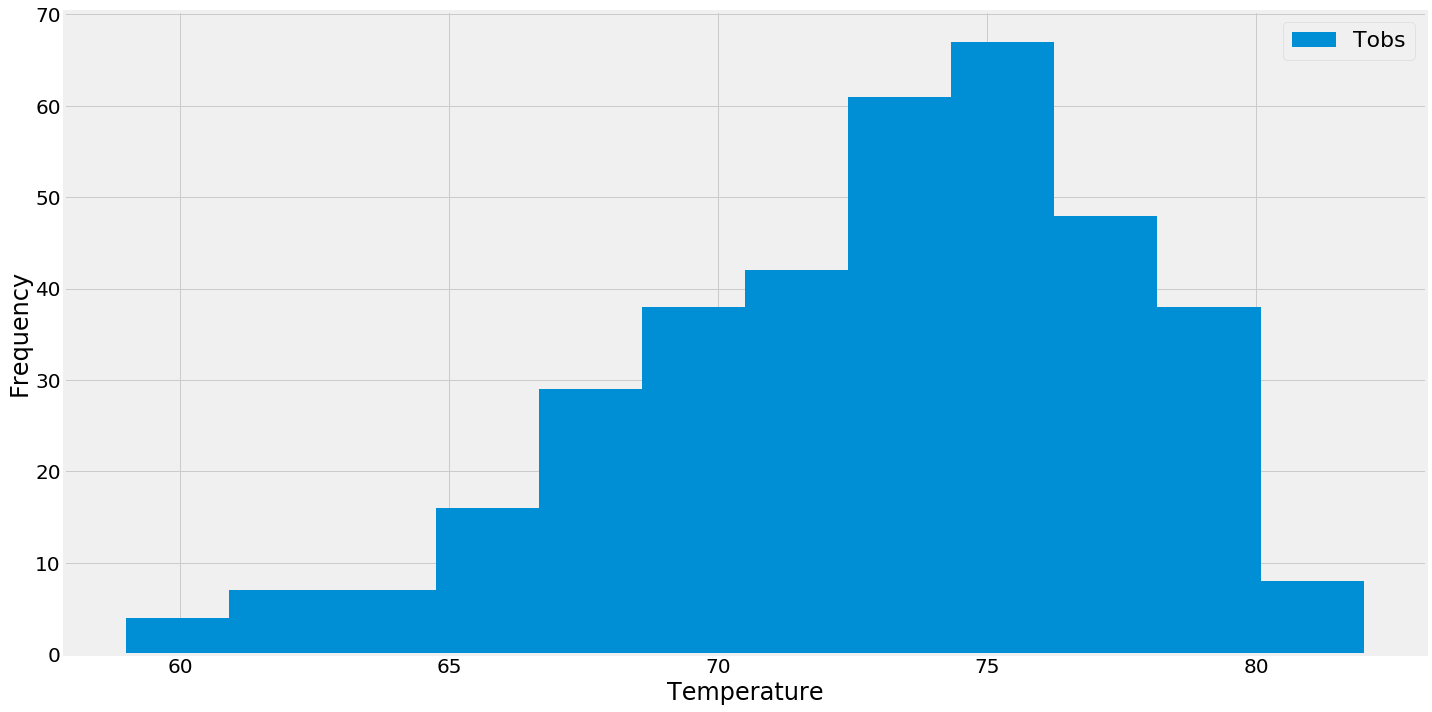

In [48]:
# Plotting histogram
plt.figure(figsize=(20,10)) 
plt.hist(usc00519281_df['Tobs'], bins=12)
plt.xlabel("Temperature", size=24)
plt.ylabel("Frequency", size=24)
plt.legend(["Tobs"], loc='best', prop={'size':22})
plt.xticks(size=20)
plt.yticks(size=20)
plt.tight_layout()
plt.show()

In [51]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example using current vacation dates
print(calc_temps('2017-04-01', '2017-04-13'))

[(67.0, 74.54761904761905, 82.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = (calc_temps('2016-04-01', '2016-04-13'))
temps

[(65.0, 73.144578313253, 78.0)]

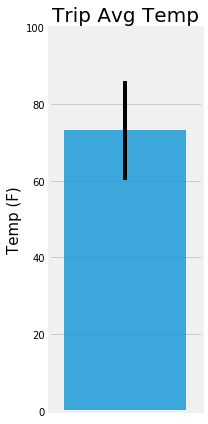

In [83]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = temps[0][2] - temps[0][0]
# peak_to_peak

x = 0
y = [temps[0][1]]

plt.figure(figsize=(3,6)) 
plt.bar(x, y, yerr=peak_to_peak, alpha=.75)
plt.title("Trip Avg Temp", size=20)
plt.ylabel("Temp (F)", size=15)
plt.yticks(size=10)
plt.ylim(0, 100)
plt.xticks([])
plt.xlim(-.5, .5)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
